In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.fft import fft,fftfreq
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor,XGBClassifier
from sklearn.metrics import mean_squared_error,precision_score, \
accuracy_score,accuracy_score,plot_confusion_matrix

%matplotlib inline

## Part 1: Data Loading and Initial Analysis

This part of the work will be carried out in different stages. The stages will involve loading the data into pandas, visualising the data and performing relevant cleaning. This will be followed by conversion of the timestamps, which are string type, to float type to enable visualisation. Finally, there will be visualisation to get some insights into the nature of the data.

**Stage1: data loading and inspection**

Initially load the data to pandas dataframe and inspect the values to get an idea of the range of values.

In [2]:
data = pd.read_csv("time.csv")
data.head()

,Unnamed: 0,timestamp,value
0,0,2014-07-01 00:00:00,10857
1,1,2014-07-01 00:30:00,8140
2,2,2014-07-01 01:00:00,6223
3,3,2014-07-01 01:30:00,4669
4,4,2014-07-01 02:00:00,3833


In [3]:
data.describe()

,Unnamed: 0,value
count,10320.000000,10320.000000
mean,5159.500000,15150.569380
std,2979.271723,6939.495808
min,0.000000,21.000000
25%,2579.750000,10275.000000
50%,5159.500000,16791.000000
75%,7739.250000,19851.750000
max,10319.000000,39210.000000


The statistics above shows that there is considerable variation in the values. However, this is to be expected of noisy time series data. The column "Unnamed: 0" serves no meaningful purpose. It is just the index in the original CSV file. Hence this column will be removed during the data cleaning stage.

**Stage 2: data cleaning**

This stage of the process involves removing irrelevant columns from the data. In this case, it will be the column "Unnamed: 0" identified in stage 1. The remaining columns will then be checked for possible missing values.

In [4]:
#....Remove column "Unnamed: 0"
data = data.drop(["Unnamed: 0"],axis=1)

#...Check for possible missing values in the remaining columns
for col_name in data.keys():
    if np.any(pd.isnull(data[col_name])):
        print("Column '{}' has missing values".format(col_name))
    else:
        print("Column '{}' has  no missing values".format(col_name))

Column 'timestamp' has  no missing values
Column 'value' has  no missing values


The output above shows that there are no missing values in the remaining columns after removing the column "Unnamed: 0". Hence there will be no need to implement any strategy to fill missing values.

**Stage 3: convert timestamps to float type data**

This stage involves converting the timestamps from strings to float. This is to enable computation with the timestamps. The Unix timestamp will be used for this purpose.

In [5]:
#...Construct Unix timestamp for the data ...
unix_time_list = []
time_format = "%Y-%m-%d %H:%M:%S"

for idx in range(len(data)):
    ts = data["timestamp"].iloc[idx]
    unix_time_list.append(datetime.strptime(ts,time_format).timestamp())
    
data["unix_timestamp"] = unix_time_list
data = data[["timestamp","unix_timestamp","value"]]
data.head()

,timestamp,unix_timestamp,value
0,2014-07-01 00:00:00,1.404169e+09,10857
1,2014-07-01 00:30:00,1.404171e+09,8140
2,2014-07-01 01:00:00,1.404173e+09,6223
3,2014-07-01 01:30:00,1.404175e+09,4669
4,2014-07-01 02:00:00,1.404176e+09,3833


In [6]:
data.tail()

,timestamp,unix_timestamp,value
10315,2015-01-31 21:30:00,1.422740e+09,24683
10316,2015-01-31 22:00:00,1.422742e+09,25734
10317,2015-01-31 22:30:00,1.422743e+09,27322
10318,2015-01-31 23:00:00,1.422745e+09,26604
10319,2015-01-31 23:30:00,1.422747e+09,26301


**Stage 4: data visualisation to check for possible anomalous values**

This stage of the process involves plotting the data in different representations to get some insghts if it contains anomalous values.

Initially plot the values along with the mean value to examine the fluctuations around the mean value.

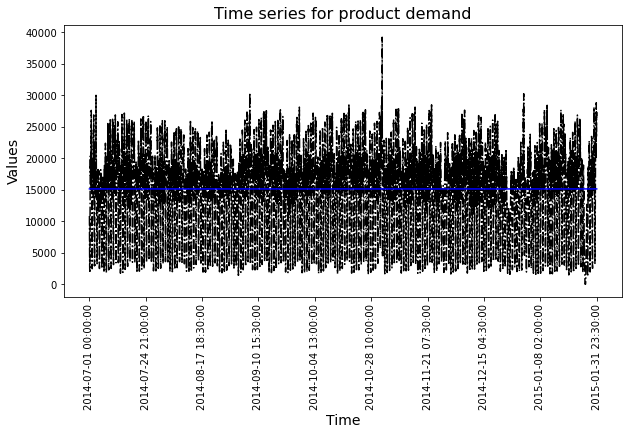

In [7]:
mean_demand = data["value"].mean()
num_ticks = 10
pos = np.linspace(0,len(data)-1,num_ticks).astype(int)
xticks = data["unix_timestamp"].iloc[pos]
xtick_labels = data["timestamp"].iloc[pos]

fig = plt.figure(figsize=(10,5))
plt.title("Time series for product demand",fontsize=16)
ax = plt.gca()
ax.plot(data["unix_timestamp"],data["value"],"k-.")
ax.plot(data["unix_timestamp"],np.ones(len(data))*mean_demand,"b-")
ax.set_xlabel("Time",fontsize=14)
ax.set_ylabel("Values",fontsize=14)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels,rotation=90)
plt.show()

The plot above shows that the values (in black) have significant fluctations above and below the mean value (in blue). This behaviour is consistent with the statistics for the data seen in Stage 1 above. However, it is not easy to see from this representation what time periods anomalous demand for the product occurred. 

More insights into possible anomalous behaviour can be gleaned from a histogram of the data. In this case, a histogram of the devations of the values from the mean will be plotted to see what the distribution looks like.

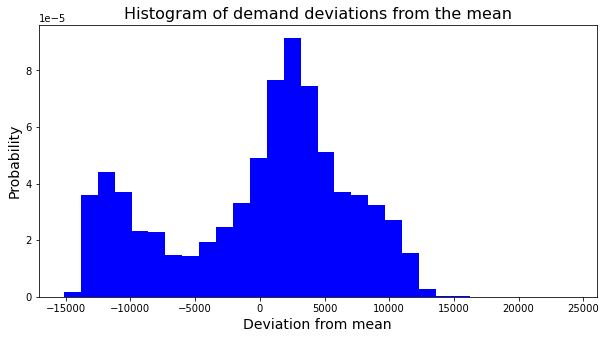

In [8]:
deviation_demand = data["value"].values - mean_demand

fig = plt.figure(figsize=(10,5))
demand_den,bin_edges,_ = plt.hist(deviation_demand, bins=30, density=True, 
                                facecolor='b')
plt.title("Histogram of demand deviations from the mean",fontsize=16)
plt.xlabel("Deviation from mean",fontsize=14)
plt.ylabel("Probability",fontsize=14)
plt.show()

The histogram above shows that the deviations from the mean value (at position zero) is not uniform. The histogram shows a major peak to the right of the mean and a minor peak to the left of the mean. the left tail of the histogram is particularly significant. This strongly suggests the presence of outliers or anomalous values in the data. 

## Part 2: Demand Forecasting

This part of the analysis will involve generating features for the time series data to train a machine learning model. This is necessary as there is no knowledge of the features on which the product demand depends on. 

The approach that will be implemented in this work to generate the features will involve transforming the data from the time domain to the frequency domain. The Fourier transform will be used for this purpose. The time series will be split into smaller time windows, and the Fourier transform will be applied to each of the time windows. This approach is valid because the coefficients of the Fourier frequencies for a particular time series can be used as a signature for that time series.

The data in each time window will be considered to represent a specific period of demand. The mean time of each time window will be the representative time for that window. The absolute values of the coefficients of the Fourier frequencies will be the features for that time period.

**Stage 1: define relevant functions**

This stage will involve defining the function to split input time series into different time windows. In addition, a function to apply Fourier transform to an input time series.

In [9]:
#...Function to split an input time series into different time windows ...
def get_time_windows(df,window_num_days,window_shift_num_days):
    num_data_pts_per_hour = 2
    num_hours_per_day = 24
    
    window_size = int(num_data_pts_per_hour*num_hours_per_day*window_num_days)
    window_shift_size = int(num_data_pts_per_hour*num_hours_per_day*\
                        window_shift_num_days)

    window_values = [] 
    mean_window_values = []
    windows_unix_timestamps = []

    for idx in range(0, len(df), window_shift_size):
        if idx+window_size>len(df):
            break
        else:
            window_values.append(
                df["value"].iloc[idx:idx+window_size].values)  
            mean_window_values.append(np.mean(
            df["value"].iloc[idx:idx+window_size].values))
            windows_unix_timestamps.append(
                np.mean(df["unix_timestamp"].iloc[idx:idx+window_size].values))

    window_values = np.array(window_values)
    windows_unix_timestamps = np.array(windows_unix_timestamps)
    return window_values,mean_window_values,windows_unix_timestamps

In [10]:
#...Function to transform input time series to frequencies ...
def perform_fft(window_values,sampling_period):
    num_amps = window_values.shape[1]//2    

    windows_fft_amps = np.abs(fft(window_values))
    windows_fft_amps = windows_fft_amps[:,:num_amps]

    #...Rescale amplitudes to the interval [0,1]...
    for idx in range(0,len(windows_fft_amps)):
        windows_fft_amps[idx,:] = windows_fft_amps[idx,:]/ \
                np.max(windows_fft_amps[idx,:])
    
    window_size = window_values.shape[1]
    windows_fft_freqs = fftfreq(window_size, d=sampling_period)
    windows_fft_freqs = windows_fft_freqs[0:num_amps]
    
    return windows_fft_amps,windows_fft_freqs

**Stage 2: generate features for demand forecasting**

This stage will involve calling the functions defined above to split the original demand time series into 1-day windows. The windows will overlap by 1/2 day. The use of overlapping time windows is important because some data signature may be split between time windows, and could be missed if the time windows do not overlap.

A time window period of 1 days and overlap of 1/2 day have been chosen here. These values may not necessarily be the best to capture the underlying signature of the data. The best approach will be to experiment with different values of the time window and overlap periods to get the best output. However, fixed values will be used here for the purpose of illustration.

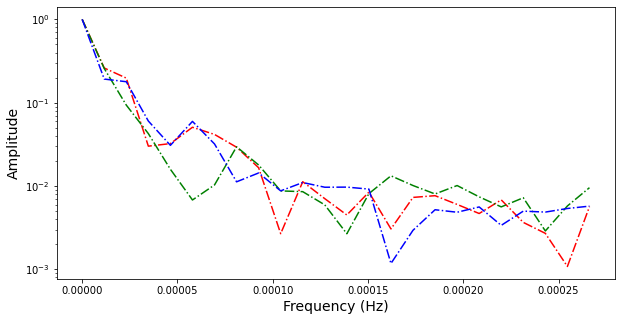

In [11]:
#...Split data to different time windows and transform to frequency domain...
window_num_days = 1
window_shift_num_days = 0.5
window_values,mean_window_values,windows_unix_timestamps = \
get_time_windows(data,window_num_days,window_shift_num_days)

sampling_period = np.diff(data["unix_timestamp"])[0]
windows_fft_amps,windows_fft_freqs = perform_fft(window_values,sampling_period)

#...Visualise some sample frequencies ...
fig = plt.figure(figsize=(10,5))
plt.semilogy(windows_fft_freqs,windows_fft_amps[0,:],"r-.")
plt.semilogy(windows_fft_freqs,windows_fft_amps[10,:],"g-.")
plt.semilogy(windows_fft_freqs,windows_fft_amps[20,:],"b-.")
plt.xlabel("Frequency (Hz)",fontsize=14)
plt.ylabel("Amplitude",fontsize=14)
plt.show()

In [12]:
#...Combine the frequencies coefficients and mean time into a single dataframe .
coeff_list = ["C"+str(idx) for idx in range(1,len(windows_fft_freqs)+1)]
transformed_data = pd.DataFrame()
transformed_data["mean_unix_time"] = windows_unix_timestamps
transformed_data[coeff_list] = windows_fft_amps
transformed_data["mean_demand"] = mean_window_values
transformed_data.head()

,mean_unix_time,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,mean_demand
0,1.404212e+09,1.0,0.260751,0.197331,0.030084,0.032295,0.050737,0.041601,0.029237,0.016580,...,0.007302,0.007657,0.006015,0.004680,0.006821,0.003661,0.002705,0.001084,0.005655,15553.979167
1,1.404255e+09,1.0,0.246197,0.186258,0.031947,0.038217,0.047646,0.036498,0.032285,0.014741,...,0.004045,0.007783,0.005173,0.009275,0.003114,0.002533,0.001345,0.001469,0.007839,15766.291667
2,1.404298e+09,1.0,0.240515,0.185794,0.018930,0.044643,0.052162,0.026351,0.025104,0.010632,...,0.004344,0.004376,0.002545,0.005381,0.005239,0.004608,0.005168,0.002883,0.006177,15297.166667
3,1.404341e+09,1.0,0.245086,0.166376,0.011446,0.046559,0.052296,0.022134,0.028123,0.012221,...,0.005777,0.003776,0.002113,0.003136,0.007103,0.005858,0.002908,0.003830,0.002640,15063.479167
4,1.404384e+09,1.0,0.243984,0.160776,0.007072,0.065239,0.042171,0.013435,0.011628,0.013422,...,0.010313,0.011952,0.008853,0.007532,0.007518,0.011128,0.013629,0.013202,0.016130,14807.625000


**Stage 3: model training and prediction**

The next stage is to train a machine learning model with the features generated in the Stage 2 and test the model. The transformed data will be split in a 70:30 ratio for training and testing. 

It is necessary to preserve the time order when training the model since the product demand occur over time. Hence the first 70% of the time series will be used for model training, and the last 30% for testing.

In [13]:
tran_fraction = 0.7
train_locs = np.arange(0,int(tran_fraction*len(transformed_data)))
test_locs = np.arange(len(train_locs),len(transformed_data))

#...Train data ...
x_train = transformed_data[coeff_list].iloc[train_locs]
y_train = transformed_data["mean_demand"].iloc[train_locs]

#...Test data ...
x_test = transformed_data[coeff_list].iloc[test_locs]
y_test = transformed_data["mean_demand"].iloc[test_locs]

#...Instantiate the regression model with default values ...
regression_model = XGBRegressor()

#...Perform training ...
regression_model.fit(x_train,y_train)

#...Perform prediction with test data ...
y_pred = regression_model.predict(x_test)

#..Check the degree of fit ...
fit_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE:",fit_rmse)

RMSE: 2002.9997493061708


The above RMSE value of about 2000 suggests that the model parameters are not optimum. The value of the RMSE can be improved upon by performing k-fold Cross Validation to obtain better model parameters. A different model can also be tested to try to get better agreements with the data.

## Part 3: Anomaly Detection

This part of the work will involve detecting the anomalies in demand whose signature was seen in the histogram in Part 1. 

Anomalies in product demand will usually occur over a period of days rather than a single day. Hence a wider time window of 3 days will be used to split the original demand time series data. The overlap time window will be increased to 1 day.

The problem will be transformed from a regression problem to a classification problem for the purpose of detecting anomalies. To achieve this, the frequencies coefficients obtain from the Fourier transform of each time window will be separated into two different classes. The separation will be based on the distance of each coefficient vector from a computed centre. This will be achieved using the k-means algorithm.

The classes obtained from the k-means algorithm will then be used to train and test a classification model.

**Stage 1: transform data into frequency domain with larger window**

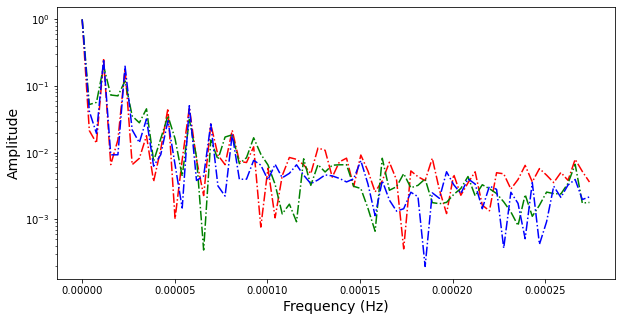

In [14]:
#...Split data to different time windows and transform to frequency domain...
window_num_days = 3
window_shift_num_days = 1
window_values,mean_window_values,windows_unix_timestamps = \
get_time_windows(data,window_num_days,window_shift_num_days)

sampling_period = np.diff(data["unix_timestamp"])[0]
windows_fft_amps,windows_fft_freqs = perform_fft(window_values,sampling_period)

#...Visualise some sample frequencies ...
fig = plt.figure(figsize=(10,5))
plt.semilogy(windows_fft_freqs,windows_fft_amps[0,:],"r-.")
plt.semilogy(windows_fft_freqs,windows_fft_amps[10,:],"g-.")
plt.semilogy(windows_fft_freqs,windows_fft_amps[20,:],"b-.")
plt.xlabel("Frequency (Hz)",fontsize=14)
plt.ylabel("Amplitude",fontsize=14)
plt.show()

In [15]:
#...Combine the frequencies coefficients and mean time into a single dataframe .
coeff_list = ["C"+str(idx) for idx in range(1,len(windows_fft_freqs)+1)]
transformed_data = pd.DataFrame()
transformed_data["mean_unix_time"] = windows_unix_timestamps
transformed_data[coeff_list] = windows_fft_amps
transformed_data["mean_demand"] = mean_window_values
transformed_data.head()

,mean_unix_time,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C64,C65,C66,C67,C68,C69,C70,C71,C72,mean_demand
0,1.404298e+09,1.0,0.021386,0.013862,0.248485,0.006596,0.015533,0.181602,0.006597,0.008200,...,0.003629,0.005760,0.004585,0.003543,0.005028,0.003831,0.007925,0.005219,0.003618,15219.590278
1,1.404384e+09,1.0,0.085277,0.074025,0.234801,0.025047,0.053335,0.129169,0.065327,0.036991,...,0.004141,0.005197,0.004828,0.004052,0.003819,0.006679,0.007818,0.001818,0.006675,13876.520833
2,1.404471e+09,1.0,0.085792,0.079527,0.232268,0.022221,0.060147,0.103892,0.071260,0.019364,...,0.006873,0.004779,0.003313,0.005491,0.006338,0.005412,0.007283,0.005303,0.008206,12639.229167
3,1.404557e+09,1.0,0.002449,0.011110,0.246155,0.025266,0.007428,0.114663,0.026025,0.024069,...,0.003371,0.001947,0.003617,0.001890,0.002534,0.002979,0.002868,0.001842,0.006925,11529.111111
4,1.404644e+09,1.0,0.060270,0.076069,0.242104,0.061065,0.072175,0.086790,0.057048,0.039361,...,0.002252,0.004162,0.001492,0.002779,0.001792,0.002794,0.005819,0.005403,0.005202,12112.479167


**Stage 2: generate classes for the features using k-means**

In [16]:
#...Extract features for clustering ...
coeffs = transformed_data[coeff_list]

#...Instantiate k-means model and train...
cluster_model = KMeans(n_clusters=2)
cluster_model.fit(coeffs)
demand_labels = cluster_model.labels_

#...Append class labels to dataframe ...
transformed_data["class"] = demand_labels

print("Number of label 0:",
     len(np.where(demand_labels==0)[0]))

print("Number of label 1:",
     len(np.where(demand_labels==1)[0]))

transformed_data.head()

Number of label 0: 131
Number of label 1: 82


,mean_unix_time,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C65,C66,C67,C68,C69,C70,C71,C72,mean_demand,class
0,1.404298e+09,1.0,0.021386,0.013862,0.248485,0.006596,0.015533,0.181602,0.006597,0.008200,...,0.005760,0.004585,0.003543,0.005028,0.003831,0.007925,0.005219,0.003618,15219.590278,1
1,1.404384e+09,1.0,0.085277,0.074025,0.234801,0.025047,0.053335,0.129169,0.065327,0.036991,...,0.005197,0.004828,0.004052,0.003819,0.006679,0.007818,0.001818,0.006675,13876.520833,0
2,1.404471e+09,1.0,0.085792,0.079527,0.232268,0.022221,0.060147,0.103892,0.071260,0.019364,...,0.004779,0.003313,0.005491,0.006338,0.005412,0.007283,0.005303,0.008206,12639.229167,0
3,1.404557e+09,1.0,0.002449,0.011110,0.246155,0.025266,0.007428,0.114663,0.026025,0.024069,...,0.001947,0.003617,0.001890,0.002534,0.002979,0.002868,0.001842,0.006925,11529.111111,1
4,1.404644e+09,1.0,0.060270,0.076069,0.242104,0.061065,0.072175,0.086790,0.057048,0.039361,...,0.004162,0.001492,0.002779,0.001792,0.002794,0.005819,0.005403,0.005202,12112.479167,0


The output above shows that the two classes are nearly balanced. This would usually not be the case. The normal behaviour would be expected to significantly outweigh the anomalous behaviour. The output suggests that more model tunning is needed to better separate the classes. 

However, the dominant class with label 0 will be treated as normal demand and the class with lable 1 will be treated as anomalous demand. The data with the class labels will be separated into train and test set to use in a classification model.

**Stage 3: separate the data into train and test set for a classification model**

The separattion will be done by taking random samples from the data using a 70:30 split.

In [17]:
#...Separate data into train and test set ...
tran_fraction = 0.7
x_train, x_test, y_train, y_test = train_test_split(
                    transformed_data[coeff_list], 
    transformed_data["class"],train_size=tran_fraction)

#...Instantiate and train a classification model ...
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)

Classification accuracy: 96.875%
Classification precision: 95.65217391304348%


Text(0.5, 1.0, 'Confusion matrix')

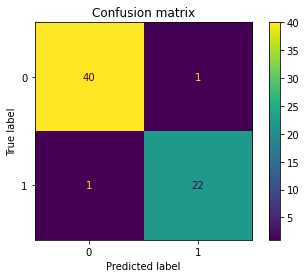

In [18]:
classification_accuracy = accuracy_score(y_test, y_pred)
classification_precision = precision_score(y_test, y_pred)

print("Classification accuracy: {}%".format(classification_accuracy*100))
print("Classification precision: {}%".format(classification_precision*100))

plot_title = "Confusion matrix"
fig = plot_confusion_matrix(xgb_model, x_test, y_test)
fig.ax_.set_title(plot_title)

The model shows a high ability to pick up the two classes judging by the accuracy and precision values. This may not be the case if the two classes are highly unbalanced.